### Experiments setup

In [1]:
from pycox import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = datasets.metabric.read_df()
feat_cols = ["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]
feats = df[feat_cols]
surv_label = df[["duration", "event"]].values

In [3]:
# Survival model to be explained
#from src.utils import convert_surv_label_structarray
#surv_label_structarray = convert_surv_label_structarray(surv_label)

#estimator = CoxPHSurvivalAnalysis().fit(feats.values.astype(float), surv_label_structarray)

0:	[0s / 0s],		train_loss: 4.7820,	val_loss: 3.9357
1:	[0s / 0s],		train_loss: 4.6994,	val_loss: 3.9193
2:	[0s / 0s],		train_loss: 4.6338,	val_loss: 3.9362
3:	[0s / 0s],		train_loss: 4.6111,	val_loss: 3.9277
4:	[0s / 0s],		train_loss: 4.5987,	val_loss: 3.9097
5:	[0s / 0s],		train_loss: 4.5905,	val_loss: 3.9115
6:	[0s / 0s],		train_loss: 4.5755,	val_loss: 3.9127
7:	[0s / 0s],		train_loss: 4.5634,	val_loss: 3.9305
8:	[0s / 0s],		train_loss: 4.5575,	val_loss: 3.9196
9:	[0s / 0s],		train_loss: 4.5748,	val_loss: 3.9120
10:	[0s / 0s],		train_loss: 4.5637,	val_loss: 3.9223
11:	[0s / 0s],		train_loss: 4.5609,	val_loss: 3.9467
12:	[0s / 0s],		train_loss: 4.5612,	val_loss: 3.9678
13:	[0s / 0s],		train_loss: 4.5525,	val_loss: 3.9652
14:	[0s / 0s],		train_loss: 4.5518,	val_loss: 3.9631


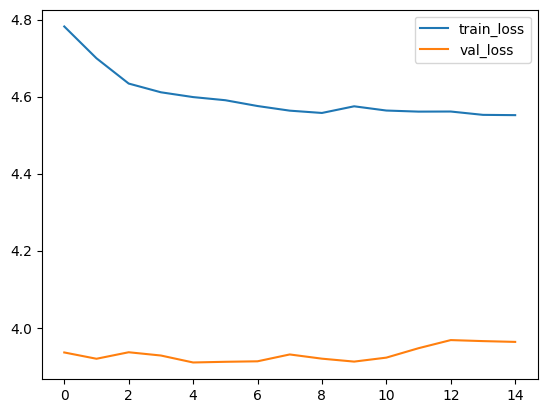

In [4]:



np.random.seed(1234)
_ = torch.manual_seed(123)

df_train = datasets.metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)


df_train.head()

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)



x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')


get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val


in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,dropout, output_bias=output_bias)


model = CoxPH(net, tt.optim.Adam)

batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
lrfinder.get_best_lr()
model.optimizer.set_lr(0.01)

epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)

_ = log.plot()
plt.show()

model.partial_log_likelihood(*val).mean()


_ = model.compute_baseline_hazards()


surv = model.predict_surv_df(x_test)


In [5]:
# Load model explainer
from src.utils import predict_survival_function_pycox
from src.utils import predict_cumulative_hazard_function_pycox
from src.explainer import explainer

def sf(newdata):
    return predict_survival_function_pycox(model,newdata)

def chf(newdata):
    return predict_cumulative_hazard_function_pycox(model,newdata)

model_explainer = explainer(model = model , data = feats , label = surv_label , sf = sf , chf = chf)

In [6]:
x_test[1,:]

array([-0.7185573 , -0.73641497,  2.2446876 ,  1.0520973 , -1.1191831 ,
        0.        ,  1.        ,  1.        ,  0.        ], dtype=float32)

In [7]:
#predict_survival_function_pycox(model,feats[:10])
model.predict_surv_df(x_test[1:2,:])

,0
duration,
0.100000,0.999502
0.766667,0.999502
1.233333,0.999502
1.266667,0.999502
1.433333,0.999502
...,...
335.600006,0.127546
335.733337,0.100660
337.033325,0.100660


In [8]:
model_explainer.model

In [9]:
model_explainer.data

,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998
...,...,...,...,...,...,...,...,...,...
1899,5.946987,5.370492,12.345780,5.741395,1.0,1.0,0.0,1.0,76.839996
1900,5.339228,5.408853,12.176101,5.693043,1.0,1.0,0.0,1.0,63.090000
1901,5.901610,5.272237,14.200950,6.139390,0.0,0.0,0.0,1.0,57.770000
1902,6.818109,5.372744,11.652624,6.077852,1.0,0.0,0.0,1.0,58.889999


In [10]:
model_explainer.label

array([[ 99.33333588,   0.        ],
       [ 95.73332977,   1.        ],
       [140.2333374 ,   0.        ],
       ...,
       [ 37.86666489,   1.        ],
       [198.43333435,   0.        ],
       [140.7666626 ,   0.        ]])

In [11]:
model_explainer.X

array([[ 5.603834 ,  7.8113923, 10.797988 , ...,  0.       ,  1.       ,
        56.84     ],
       [ 5.2848816,  9.581043 , 10.20462  , ...,  0.       ,  1.       ,
        85.94     ],
       [ 5.920251 ,  6.776564 , 12.431715 , ...,  0.       ,  1.       ,
        48.44     ],
       ...,
       [ 5.90161  ,  5.2722373, 14.20095  , ...,  0.       ,  1.       ,
        57.77     ],
       [ 6.8181086,  5.372744 , 11.652624 , ...,  0.       ,  1.       ,
        58.89     ],
       [ 5.725708 ,  5.4497185,  9.680736 , ...,  0.       ,  0.       ,
        60.63     ]], dtype=float32)

In [12]:
model_explainer.sf(model_explainer.X[1:10,:])

In [13]:
model_explainer.chf(model_explainer.X[1:10,:])

TypeError: object of type 'int' has no len()

### Prediction

In [7]:
from src import prediction
# select first 10 observations to be explained
explained_data = feats[:10]
# Survival prediction
surv_pred = prediction.predict(model_explainer, explained_data)
#prediction.plot_prediction(surv_pred, "survival")

AttributeError: 'CoxPH' object has no attribute 'input_cols'

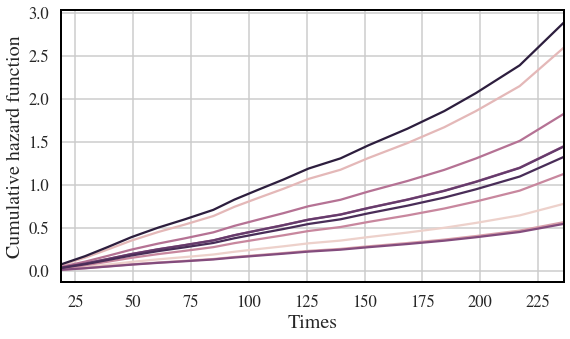

In [6]:
# Cumulative hazard prediction
chf_pred = prediction.predict(model_explainer, explained_data, type="chf")
prediction.plot_prediction(chf_pred, "chf")

### Performance

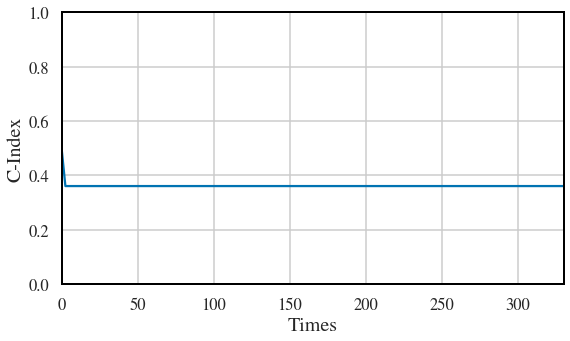

In [7]:
from src import performance
eval_times = np.unique(surv_label[:, 0])[::10]

# C-Index evaluation
cindex_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="c_index")
performance.plot_performance(cindex_perf, metric="c_index")

In [8]:
print(cindex_perf.head(20))

        times      perf
0    0.000000  0.500000
1    2.500000  0.360849
2    5.500000  0.360851
3    9.600000  0.360851
4   11.700000  0.360851
5   14.166667  0.360851
6   15.366667  0.360851
7   16.600000  0.360851
8   18.233334  0.360851
9   19.566668  0.360851
10  20.666666  0.360851
11  21.933332  0.360851
12  23.366667  0.360851
13  24.333334  0.360851
14  25.466667  0.360851
15  27.200001  0.360851
16  28.566668  0.360851
17  29.666666  0.360851
18  30.866667  0.360851
19  31.799999  0.360851


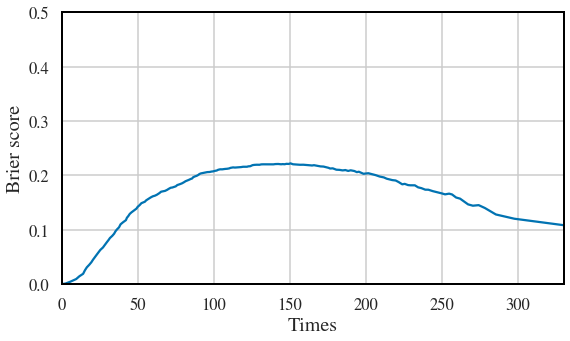

In [9]:
# Brier score evaluation
bs_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="brier_score")
performance.plot_performance(bs_perf, metric="brier_score")

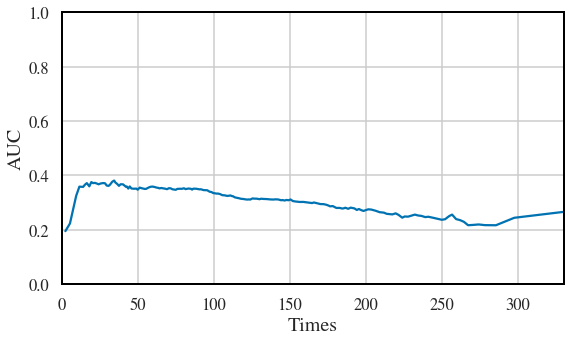

In [10]:
# AUC evaluation
auc_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="auc")
performance.plot_performance(auc_perf, metric="auc")

### Local explaination

In [11]:
from src import local_explaination

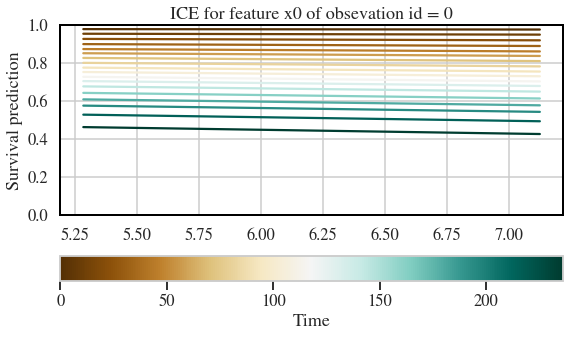

In [12]:
# individual conditional expectation
explained_feature = "x0"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, explained_feature, n_sel_samples=10)
local_explaination.plot_ICE(ICE_df)

In [13]:
# SurvLIME
SurvLIME_df = local_explaination.SurvLIME(model_explainer, explained_data, surv_label, 100)

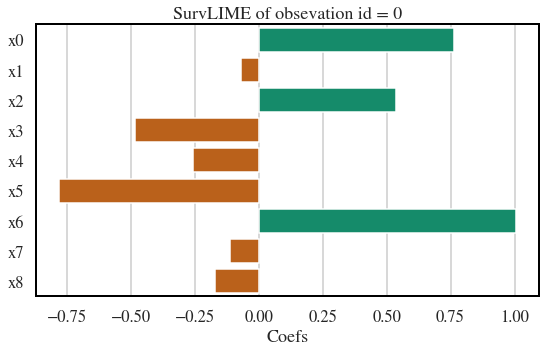

In [14]:
local_explaination.plot_SurvLIME(SurvLIME_df)

### Global explaination

In [15]:
from src import global_explaination

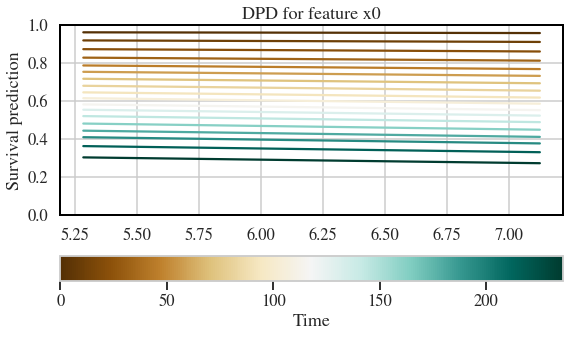

In [16]:
# partial dependence plot
explained_feature = "x0"
PDP_df = global_explaination.partial_dependence_plots(model_explainer, explained_feature, n_sel_samples=10)
global_explaination.plot_PDP(PDP_df)